## 加载数据集

In [115]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import Random
from collections import defaultdict

import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.data import DataLoader

from rdkit import Chem
from rdkit.Chem.BRICS import FindBRICSBonds
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger

In [116]:
# -------------------------------------
# attentive_fp fashion featurization
# -------------------------------------
def onehot_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def onehot_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_attr(mol, explicit_H=False, use_chirality=True, pharmaco=True, scaffold=True):
    if pharmaco:
        mol = tag_pharmacophore(mol)
    if scaffold:
        mol = tag_scaffold(mol)

    feat = []
    for i, atom in enumerate(mol.GetAtoms()):
        results = onehot_encoding_unk(
            atom.GetSymbol(),
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At', 'other'
             ]) + onehot_encoding_unk(atom.GetDegree(),
                                      [0, 1, 2, 3, 4, 5, 'other']) + \
                  [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                  onehot_encoding_unk(atom.GetHybridization(), [
                      Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                      Chem.rdchem.HybridizationType.SP3D2, 'other'
                  ]) + [atom.GetIsAromatic()]
        if not explicit_H:
            results = results + onehot_encoding_unk(atom.GetTotalNumHs(),
                                                    [0, 1, 2, 3, 4])
        if use_chirality:
            try:
                results = results + onehot_encoding_unk(
                    atom.GetProp('_CIPCode'),
                    ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
            # print(one_of_k_encoding_unk(atom.GetProp('_CIPCode'), ['R', 'S']) + [atom.HasProp('_ChiralityPossible')])
            except:
                results = results + [0, 0] + [atom.HasProp('_ChiralityPossible')]
        if pharmaco:
            results = results + [int(atom.GetProp('Hbond_donor'))] + [int(atom.GetProp('Hbond_acceptor'))] + \
                      [int(atom.GetProp('Basic'))] + [int(atom.GetProp('Acid'))] + \
                      [int(atom.GetProp('Halogen'))]
        if scaffold:
            results = results + [int(atom.GetProp('Scaffold'))]
        feat.append(results)

    return np.array(feat)


def bond_attr(mol, use_chirality=True):
    feat = []
    index = []
    n = mol.GetNumAtoms()
    for i in range(n):
        for j in range(n):
            if i != j:
                bond = mol.GetBondBetweenAtoms(i, j)
                if bond is not None:
                    bt = bond.GetBondType()
                    bond_feats = [
                        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                        bond.GetIsConjugated(),
                        bond.IsInRing()
                    ]
                    if use_chirality:
                        bond_feats = bond_feats + onehot_encoding_unk(
                            str(bond.GetStereo()),
                            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
                    feat.append(bond_feats)
                    index.append([i, j])

    return np.array(index), np.array(feat)


def bond_break(mol):
    results = np.array(sorted(list(FindBRICSBonds(mol))), dtype=np.long)

    if results.size == 0:
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(mol, asMols=True, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(mol)

    else:
        bond_to_break = results[:, 0, :]
        bond_to_break = bond_to_break.tolist()
        with Chem.RWMol(mol) as rwmol:
            for i in bond_to_break:
                rwmol.RemoveBond(*i)
        rwmol = rwmol.GetMol()
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(rwmol, asMols=True, sanitizeFrags=False, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(rwmol)
        cluster_idx = torch.LongTensor(cluster_idx)

    return fra_edge_index, fra_edge_attr, cluster_idx

In [117]:
# ---------------------------------------------
# Scaffold and pharmacophore information utils
# ---------------------------------------------
# tag pharmoco features to each atom
fun_smarts = {
        'Hbond_donor': '[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]',
        'Hbond_acceptor': '[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),n&X2&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]',
        'Basic': '[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]),$([n;X2;+0;-0])]',
        'Acid': '[C,S](=[O,S,P])-[O;H1,-1]',
        'Halogen': '[F,Cl,Br,I]'
        }
FunQuery = dict([(pharmaco, Chem.MolFromSmarts(s)) for (pharmaco, s) in fun_smarts.items()])


def tag_pharmacophore(mol):
    for fungrp, qmol in FunQuery.items():
        matches = mol.GetSubstructMatches(qmol)
        match_idxes = []
        for mat in matches:
            match_idxes.extend(mat)
        for i, atom in enumerate(mol.GetAtoms()):
            tag = '1' if i in match_idxes else '0'
            atom.SetProp(fungrp, tag)
    return mol


# tag scaffold information to each atom
def tag_scaffold(mol):
    core = MurckoScaffold.GetScaffoldForMol(mol)
    match_idxes = mol.GetSubstructMatch(core)
    for i, atom in enumerate(mol.GetAtoms()):
        tag = '1' if i in match_idxes else '0'
        atom.SetProp('Scaffold', tag)
    return mol

In [118]:
# ---------------------------------
# data and dataset
# ---------------------------------
class MolData(Data):
    def __init__(self, fra_edge_index=None, fra_edge_attr=None, cluster_index=None, **kwargs):
        super(MolData, self).__init__(**kwargs)
        self.cluster_index = cluster_index
        self.fra_edge_index = fra_edge_index
        self.fra_edge_attr = fra_edge_attr

    def __inc__(self, key, value, *args, **kwargs):
        if key == 'cluster_index':
            return int(self.cluster_index.max()) + 1
        else:
            return super().__inc__(key, value, *args, **kwargs)


class MolDataset(InMemoryDataset):

    def __init__(self, root, dataset, task_type, tasks, logger=None,
                 transform=None, pre_transform=None, pre_filter=None):

        self.tasks = tasks
        self.dataset = dataset
        self.task_type = task_type

        super(MolDataset, self).__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['{}.csv'.format(self.dataset)]

    @property
    def processed_file_names(self):
        return ['{}.pt'.format(self.dataset)]

    def download(self):
        pass

    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        smilesList = df.smiles.values
        print(f'number of all smiles: {len(smilesList)}')
        remained_smiles = []
        canonical_smiles_list = []
        for smiles in smilesList:
            try:
                canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
                remained_smiles.append(smiles)
            except:
                print(f'not successfully processed smiles: {smiles}')
                pass
        print(f'number of successfully processed smiles: {len(remained_smiles)}')

        df = df[df["smiles"].isin(remained_smiles)].reset_index()
        target = df[self.tasks].values
        smilesList = df.smiles.values
        data_list = []

        for i, smi in enumerate(tqdm(smilesList)):

            mol = Chem.MolFromSmiles(smi)
            data = self.mol2graph(mol)

            if data is not None:
                label = target[i]
                label[np.isnan(label)] = 666
                data.y = torch.LongTensor([label])
                if self.task_type == 'regression':
                    data.y = torch.FloatTensor([label])
                data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def mol2graph(self, mol):
        smiles = Chem.MolToSmiles(mol)
        if mol is None: return None
        node_attr = atom_attr(mol)
        edge_index, edge_attr = bond_attr(mol)
        fra_edge_index, fra_edge_attr, cluster_index = bond_break(mol)
        data = MolData(
            x=torch.FloatTensor(node_attr),
            edge_index=torch.LongTensor(edge_index).t(),
            edge_attr=torch.FloatTensor(edge_attr),
            fra_edge_index=torch.LongTensor(fra_edge_index).t(),
            fra_edge_attr=torch.FloatTensor(fra_edge_attr),
            cluster_index=torch.LongTensor(cluster_index),
            y=None,
            smiles=smiles,
        )
        return data

## 定义模型

In [119]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, Parameter, Bilinear

from torch_scatter import scatter
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset
from torch_geometric.nn.pool.pool import pool_batch
from torch_geometric.nn.pool.consecutive import consecutive_cluster

In [120]:
# ---------------------------------------
# Attention layers
# ---------------------------------------
class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce='max')
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce='sum')
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y

In [121]:
# ---------------------------------------
# Neural tensor networks conv
# ---------------------------------------
class NTNConv(MessagePassing):

    def __init__(self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels,
                                                  out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim,
                                                      out_channels))
        else:
            self.weight_edge = self.register_parameter('weight_edge', None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):

        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = x_j.view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out

    def __repr__(self):
        return '{}({}, {}, slices={})'.format(self.__class__.__name__,
                                              self.in_channels,
                                              self.out_channels, self.slices)

In [122]:
# ---------------------------------------
# HiGNN backbone
# ---------------------------------------
class HiGNN(torch.nn.Module):
    """Hierarchical informative graph neural network for molecular representation.

    """

    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers,
                 slices, dropout, f_att=False, r=4, brics=True, cl=False):
        super(HiGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.f_att = f_att
        self.brics = brics
        self.cl = cl

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(hidden_channels, hidden_channels, slices=slices,
                           dropout=dropout, edge_dim=hidden_channels)
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        if self.brics:
            # mol-fra attention
            self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout=dropout, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        if self.brics:
            self.out = Linear(2 * hidden_channels, out_channels)
        else:
            self.out = Linear(hidden_channels, out_channels)

        if self.cl:
            self.lin_project = Linear(hidden_channels, int(hidden_channels/2))

        self.reset_parameters()

    def reset_parameters(self):

        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        if self.brics:
            self.cross_att.reset_parameters()

        self.out.reset_parameters()

        if self.cl:
            self.lin_project.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = self.atom_convs[i](x, edge_index, edge_attr)
            h = F.relu(h)
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol_vec = global_add_pool(x, batch).relu_()

        if self.brics:
            # get fragment input
            fra_x = data.x
            fra_edge_index = data.fra_edge_index
            fra_edge_attr = data.fra_edge_attr
            cluster = data.cluster_index

            fra_x = F.relu(self.lin_a(fra_x))  # (N, 46) -> (N, hidden_channels)
            fra_edge_attr = F.leaky_relu_(self.lin_b(fra_edge_attr))  # (N, 10) -> (N, hidden_channels)

            # fragment convs block
            for i in range(0, self.num_layers):
                fra_h = F.relu(self.atom_convs[i](fra_x, fra_edge_index, fra_edge_attr))
                beta = self.lin_gate(torch.cat([fra_x, fra_h, fra_x - fra_h], 1)).sigmoid()
                fra_x = beta * fra_x + (1 - beta) * fra_h
                if self.f_att:
                    fra_x = self.feature_att(fra_x, cluster)

            fra_x = global_add_pool(fra_x, cluster).relu_()

            # get fragment batch
            cluster, perm = consecutive_cluster(cluster)
            fra_batch = pool_batch(perm, data.batch)

            # molecule-fragment attention
            row = torch.arange(fra_batch.size(0), device=batch.device)
            mol_fra_index = torch.stack([row, fra_batch], dim=0)
            fra_vec = self.cross_att((fra_x, mol_vec), mol_fra_index)
            fra_vec = fra_vec.relu()

            vectors_concat = list()
            vectors_concat.append(mol_vec)
            vectors_concat.append(fra_vec)

            out = torch.cat(vectors_concat, 1)

            # molecule-fragment contrastive
            if self.cl:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out), self.lin_project(mol_vec).relu_(), self.lin_project(fra_vec).relu_()
            else:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out)

        else:
            assert self.cl is False
            out = F.dropout(mol_vec, p=self.dropout, training=self.training)
            return self.out(out)

## 加载数据

In [125]:
import csv
def get_header(path):
    with open(path) as f:
        header = next(csv.reader(f))

    return header


def get_task_names(path, use_compound_names=False):
    index = 2 if use_compound_names else 1
    task_names = get_header(path)[index:]

    return task_names

task_names = get_task_names('E:/3-Code/Jupternote book/HiGNN_Vis/raw/bace.csv')

In [135]:
path = 'E:/3-Code/Jupternote book/HiGNN_Vis'
dataset = 'bace'
task_type = 'classification'
tasks = task_names
bace = MolDataset(root=path, dataset=dataset, task_type=task_type, tasks=tasks)
print(len(bace))

1513


## 进行预测

In [245]:
def load_best_result(model, seed=2021):
    best_ckpt_path = f'E:/3-Code/Jupternote book/HiGNN_Vis/ckpt/bace_random_best_ckpt_{seed}.pth'
    ckpt = torch.load(best_ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(ckpt['model'])

    return model

In [246]:
# ---------------------------------------
# Build HiGNN 
# ---------------------------------------
model = HiGNN(in_channels=46,
              hidden_channels=256,
              out_channels=2,
              edge_dim=10,
              num_layers=4,
              dropout=0.1,
              slices=1,
              f_att=True,
              r=2,
              brics=True,
              cl=False)

In [247]:
from sklearn import metrics
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 200)

In [248]:
# 计算tpr, auc
for seed in range(2021,2031):
    # 随机种子
    random = Random(seed)
    indices = list(range(len(bace)))
    random.seed(seed)
    random.shuffle(indices)

    train_size = int(0.8 * len(bace))
    val_size = int(0.1 * len(bace))
    test_size = len(bace) - train_size - val_size

    trn_id, val_id, test_id = indices[:train_size], \
                              indices[train_size:(train_size + val_size)], \
                              indices[(train_size + val_size):]

    # 确定模型
    model = load_best_result(model, seed)

    # 加载测试集数据
    bace_test = bace[test_id]
    loader = DataLoader(bace_test, batch_size=152)
    iter_ = iter(loader)
    batch = next(iter_)

    # 进行预测
    model.eval()  # 关闭dropout
    output = model(batch)
    pred = F.softmax(output.detach(), dim=-1)[:, 1].view(-1).numpy()

    # 获取原标签
    label = batch.y
    
    # 计算roc_auc
    fpr, tpr, threshold = metrics.roc_curve(label, pred)
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

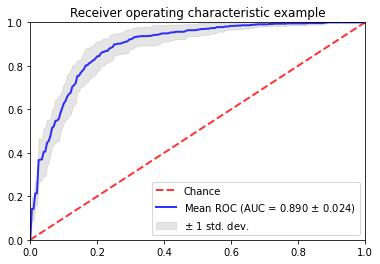

In [249]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[0, 1],
    ylim=[0, 1],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [250]:
def load_best_result_no(model, seed=2021):
    best_ckpt_path = f'E:/3-Code/Jupternote book/HiGNN_Vis/ckpt/bace_noall_best_ckpt_{seed}.pth'
    ckpt = torch.load(best_ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(ckpt['model'])

    return model

In [251]:
# ---------------------------------------
# Build HiGNN 
# ---------------------------------------
model2 = HiGNN(in_channels=46,
               hidden_channels=256,
               out_channels=2,
               edge_dim=10,
               num_layers=4,
               dropout=0.1,
               slices=1,
               f_att=False,
               r=2,
               brics=False,
               cl=False)

In [252]:
from sklearn import metrics
tprs2 = []
aucs2 = []
mean_fpr2 = np.linspace(0, 1, 200)

In [253]:
# 计算tpr, auc
for seed in range(2021,2031):
    # 随机种子
    random = Random(seed)
    indices = list(range(len(bace)))
    random.seed(seed)
    random.shuffle(indices)

    train_size = int(0.8 * len(bace))
    val_size = int(0.1 * len(bace))
    test_size = len(bace) - train_size - val_size

    trn_id, val_id, test_id = indices[:train_size], \
                              indices[train_size:(train_size + val_size)], \
                              indices[(train_size + val_size):]

    # 确定模型
    model = load_best_result_no(model2, seed)

    # 加载测试集数据
    bace_test = bace[test_id]
    loader = DataLoader(bace_test, batch_size=152)
    iter_ = iter(loader)
    batch = next(iter_)

    # 进行预测
    model.eval()  # 关闭dropout
    output = model(batch)
    pred = F.softmax(output.detach(), dim=-1)[:, 1].view(-1).numpy()

    # 获取原标签
    label = batch.y
    
    # 计算roc_auc
    fpr, tpr, threshold = metrics.roc_curve(label, pred)
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr2, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs2.append(interp_tpr)
    aucs2.append(roc_auc)

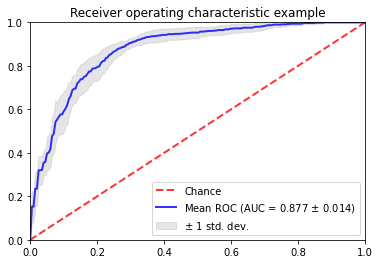

In [254]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr2[-1] = 1.0
mean_auc2 = metrics.auc(mean_fpr2, mean_tpr2)
std_auc2 = np.std(aucs2)
ax.plot(
    mean_fpr2,
    mean_tpr2,
    color="b",
    label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc2, std_auc2),
    lw=2,
    alpha=0.8,
)

std_tpr2 = np.std(tprs2, axis=0)
tprs_upper2 = np.minimum(mean_tpr2 + std_tpr2, 1)
tprs_lower2 = np.maximum(mean_tpr2 - std_tpr2, 0)
ax.fill_between(
    mean_fpr2,
    tprs_lower2,
    tprs_upper2,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[0, 1],
    ylim=[0, 1],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

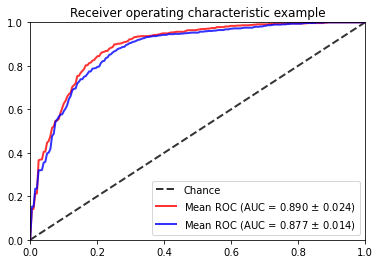

In [255]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="r",
    label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.plot(
    mean_fpr2,
    mean_tpr2,
    color="b",
    label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc2, std_auc2),
    lw=2,
    alpha=0.8,
)
ax.set(
    xlim=[0, 1],
    ylim=[0, 1],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [256]:
mean_fpr

array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
       0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
       0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
       0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
       0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
       0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
       0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
       0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
       0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
       0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
       0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
       0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
       0.35175879, 0.35678392, 0.36180905, 0.36683417, 0.37185

In [257]:
mean_tpr

array([0.        , 0.14203398, 0.14203398, 0.21302851, 0.21302851,
       0.3659088 , 0.36864853, 0.37018699, 0.40429799, 0.40614984,
       0.44607018, 0.45428936, 0.47713666, 0.51506925, 0.5212231 ,
       0.5470144 , 0.54838426, 0.55606029, 0.58415213, 0.60500045,
       0.62745909, 0.63834931, 0.65866914, 0.66980088, 0.67577103,
       0.70301524, 0.71140301, 0.71981571, 0.75307138, 0.75456391,
       0.76800047, 0.77677774, 0.78530893, 0.80248333, 0.80248333,
       0.8122838 , 0.8151462 , 0.82387705, 0.82686213, 0.8361865 ,
       0.84459809, 0.84459809, 0.85742427, 0.8630264 , 0.86456486,
       0.86879021, 0.86879021, 0.87909277, 0.88322138, 0.88618842,
       0.89890944, 0.89890944, 0.90181042, 0.90181042, 0.903239  ,
       0.90647974, 0.90933688, 0.91082942, 0.91375677, 0.92220747,
       0.92220747, 0.92679905, 0.93243285, 0.93243285, 0.93526987,
       0.93526987, 0.93669845, 0.93669845, 0.93669845, 0.93669845,
       0.93669845, 0.93819098, 0.93819098, 0.94096876, 0.94233

In [258]:
mean_fpr2

array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
       0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
       0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
       0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
       0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
       0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
       0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
       0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
       0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
       0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
       0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
       0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
       0.35175879, 0.35678392, 0.36180905, 0.36683417, 0.37185

In [259]:
mean_tpr2

array([0.        , 0.15244457, 0.15244457, 0.23501315, 0.23501315,
       0.31972169, 0.31972169, 0.32126015, 0.35473528, 0.35843899,
       0.39716012, 0.40086383, 0.41760321, 0.47688501, 0.48765424,
       0.54187301, 0.55283192, 0.56539079, 0.57659971, 0.57659971,
       0.59205355, 0.60349444, 0.61927269, 0.64726771, 0.66070054,
       0.68706074, 0.69453852, 0.6959671 , 0.71971568, 0.72717836,
       0.73851785, 0.73851785, 0.7498257 , 0.75273402, 0.76273402,
       0.77424209, 0.77424209, 0.78699003, 0.78848257, 0.78991114,
       0.79552538, 0.79689524, 0.81272871, 0.82121226, 0.82275072,
       0.83584721, 0.83892413, 0.85057701, 0.85331674, 0.86121255,
       0.86684635, 0.87006806, 0.87744666, 0.88018639, 0.88304353,
       0.8873989 , 0.8873989 , 0.8958496 , 0.89862738, 0.90434527,
       0.90588373, 0.91011599, 0.91165445, 0.91489519, 0.91922475,
       0.92061364, 0.92353475, 0.92648166, 0.9279742 , 0.93232956,
       0.93232956, 0.93386803, 0.93527648, 0.93666536, 0.93666

In [260]:
df = pd.DataFrame()

In [261]:
df['fpr'] = mean_fpr
df['tpr1'] = mean_tpr
df['tpr2'] = mean_tpr2

In [263]:
df.to_csv('bace_auc.csv')